In [1]:
import torch
from torch import nn
import numpy as np
import os
class FacePredict(nn.Module):
    def __init__(self):
        """
        Initialize using a pretrained tf model
        """
        super().__init__()
        self.lstm = nn.LSTM(28, 60)
        #self.dropout = nn.Dropout(p=0.5)
        self.dense = nn.Linear(60, 20)
        
    def forward(self, inputs):
        hid0, _ = self.lstm(inputs)
        #hiddrop = self.dropout(hid0)
        return self.dense(hid0)
    
    def load_weights_tf(self):
        #get the weights from tf model
        with torch.no_grad():
            #reorder weights to convert from tf to torch
            wii, wic, wif, wio = np.split(weights[2][:28, :], 4, 1)
            whi, whc, whf, who = np.split(weights[2][28:, :], 4, 1)
            wih = np.concatenate((wii, wif, wic, wio), axis = 1)
            whh = np.concatenate((whi, whf, whc, who), axis = 1)

            self.lstm.weight_ih_l0.data = torch.from_numpy(wih).transpose(0,1)
            self.lstm.weight_hh_l0.data = torch.from_numpy(whh).transpose(0,1)
            self.lstm.bias_hh_l0.data = torch.from_numpy(weights[3])
            self.lstm.bias_ih_l0.data = torch.zeros((240))

            self.dense.weight.data = torch.from_numpy(weights[0].T)
            self.dense.bias.data = torch.from_numpy(weights[1])


In [2]:
def get_audio_derivatives(audio):
    #calculate audio derivatives, return timestamps too
    audiodiff = audio[1:,:-1] - audio[:-1, :-1]
    times = audio[:, -1]
    return np.concatenate((audio[:-1, :-1], audiodiff[:, :]), axis=1), times

def shifted_time(i, times):
      if i >= 20:
        return times[i - 20]
      else:
        return times[0]

In [3]:
class FacePredictFineTune(FacePredict):
    def __init__(self):
        super().__init__()
        self.dense_input = nn.Linear(28, 28, bias = False)
        
        nn.init.xavier_uniform_(self.dense_input.weight)
        
        nn.init.xavier_uniform_(self.dense.weight)
        nn.init.zeros_(self.dense.bias)
        
        self.bn = nn.BatchNorm1d(28) #batch normalization on inputs
    def forward(self, inputs):
        #shape T*B*D (time*batch*num_feat)
        inputs_transformed = self.dense_input(inputs)
        inputs_norm = self.bn(inputs_transformed.transpose(1,2)).transpose(1,2)
        hid0, _ = self.lstm(inputs_norm)
        #hiddrop = self.dropout(hid0)
        return self.dense(hid0)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
model = FacePredictFineTune()
model.load_state_dict(torch.load('/content/drive/MyDrive/6869/face predict'))
model.double()
#torch.save(fpf.state_dict(), 'face predict')

FacePredictFineTune(
  (lstm): LSTM(28, 60)
  (dense): Linear(in_features=60, out_features=20, bias=True)
  (dense_input): Linear(in_features=28, out_features=28, bias=False)
  (bn): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [6]:
audio_preprocessed = np.load('/content/drive/MyDrive/6869/xAAmF3H0-ek_audio.npy')
audio_data = get_audio_derivatives(audio_preprocessed)[0]
print(audio_data.shape)

(57190, 28)


In [7]:
video_data = np.load('/content/drive/MyDrive/6869/xAAmF3H0-ek_landmarks_frontalized.npy').reshape(-1, 25, 2)
video_lip_fiducials = video_data[:, 5:].reshape(-1, 40)
video_lip_fiducials.shape

(16947, 40)

In [8]:
#crop and shift of video, in seconds
video_start = 12*100//30
video_end = 16958*100//30 #inclusive
video_shft = 20
video_start

40

In [9]:
#preprocess video using pca
from sklearn.decomposition import PCA
pca = PCA(n_components = 20)
lip_features = pca.fit_transform(video_lip_fiducials)

#upsampling
from scipy.interpolate import interp1d
video_times = np.arange(12, 16959)/30
lips_interpolate = interp1d(video_times, lip_features, axis = 0)
audio_times = np.arange(video_start, video_end)/100
lips_upsampled = lips_interpolate(audio_times)

In [10]:
from torch.utils.data import Dataset, DataLoader
import os
class FacePredictDataset(Dataset):
    def __init__(self, inputs, outputs, predict_delay, output_begin, num_cuts = 18):
        #temporally inputs[output_begin] matches with outputs[0]
        #in rnn match inputs[output_begin + predict_delay] with outputs[0] 

        #crop outputs
        output_length = len(outputs)
        crop_len = output_length // num_cuts
        self.outputs = [outputs[crop_len*n:crop_len*(n+1)] for n in range(num_cuts)]

        #find matching parts of inputs
        self.inputs = [inputs[crop_len*n + output_begin: crop_len*(n+1) + output_begin + predict_delay] for n in range(num_cuts)]
        self.len = num_cuts
        self.crop_len = crop_len

    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        return [self.inputs[idx], self.outputs[idx], self.crop_len * idx]

In [11]:
data = FacePredictDataset(audio_data, lips_upsampled, video_shft, video_start, 100)
train_data, test_data = torch.utils.data.random_split(data, [80, 20])
test_dataloader = DataLoader(test_data, batch_size=20, shuffle=True)

In [12]:
from torch import optim
def delay_loss(preds, y, loss, delay):
    return loss(preds[:, delay:, :], y)

loss = nn.MSELoss()







  0%|          | 0/20000 [00:00<?, ?it/s]




  0%|          | 5/20000 [00:00<07:07, 46.79it/s]




  0%|          | 19/20000 [00:00<05:44, 58.03it/s]

epoch:  0
training loss: 15.325918746836495
validation loss: 12.577046303203232







  0%|          | 32/20000 [00:00<04:48, 69.27it/s]




  0%|          | 45/20000 [00:00<04:09, 79.84it/s]




  0%|          | 57/20000 [00:00<03:45, 88.56it/s]




  0%|          | 70/20000 [00:00<03:25, 97.06it/s]




  0%|          | 83/20000 [00:00<03:12, 103.48it/s]




  0%|          | 96/20000 [00:00<03:04, 108.15it/s]




  1%|          | 108/20000 [00:00<03:01, 109.38it/s]




  1%|          | 121/20000 [00:01<02:55, 113.57it/s]




  1%|          | 133/20000 [00:01<02:53, 114.76it/s]




  1%|          | 145/20000 [00:01<02:55, 113.38it/s]




  1%|          | 157/20000 [00:01<02:52, 114.90it/s]




  1%|          | 170/20000 [00:01<02:47, 118.28it/s]




  1%|          | 183/20000 [00:01<02:46, 119.31it/s]




  1%|          | 196/20000 [00:01<02:42, 121.96it/s]




  1%|          | 209/20000 [00:01<02:41, 122.68it/s]




  1%|          | 222/20000 [00:01<02:39, 124.05it/s]




  1%|          | 235/20000 [00:01<02:42, 121.34it/s]




  1%|          | 248/20000 [00:02<02

epoch:  1000
training loss: 0.7274059015063884
validation loss: 12.088641197973352







  5%|▌         | 1031/20000 [00:08<02:48, 112.68it/s]




  5%|▌         | 1043/20000 [00:08<02:45, 114.26it/s]




  5%|▌         | 1055/20000 [00:08<02:47, 113.17it/s]




  5%|▌         | 1067/20000 [00:08<02:44, 114.78it/s]




  5%|▌         | 1079/20000 [00:08<02:46, 113.63it/s]




  5%|▌         | 1091/20000 [00:08<02:45, 114.56it/s]




  6%|▌         | 1103/20000 [00:08<02:48, 112.42it/s]




  6%|▌         | 1116/20000 [00:09<02:43, 115.52it/s]




  6%|▌         | 1129/20000 [00:09<02:39, 118.40it/s]




  6%|▌         | 1142/20000 [00:09<02:35, 121.10it/s]




  6%|▌         | 1155/20000 [00:09<02:32, 123.40it/s]




  6%|▌         | 1169/20000 [00:09<02:29, 126.34it/s]




  6%|▌         | 1182/20000 [00:09<02:31, 124.56it/s]




  6%|▌         | 1195/20000 [00:09<02:32, 123.21it/s]




  6%|▌         | 1208/20000 [00:09<02:32, 123.46it/s]




  6%|▌         | 1221/20000 [00:09<02:31, 123.68it/s]




  6%|▌         | 1234/20000 [00:10<02:36, 120.01it/s]




  6%|▌   

epoch:  2000
training loss: 0.26984535197301596
validation loss: 13.232145249214105







 10%|█         | 2034/20000 [00:16<02:36, 115.06it/s]




 10%|█         | 2048/20000 [00:16<02:29, 120.14it/s]




 10%|█         | 2061/20000 [00:16<02:26, 122.35it/s]




 10%|█         | 2074/20000 [00:16<02:27, 121.42it/s]




 10%|█         | 2087/20000 [00:16<02:26, 122.40it/s]




 10%|█         | 2100/20000 [00:17<02:27, 121.00it/s]




 11%|█         | 2113/20000 [00:17<02:27, 121.12it/s]




 11%|█         | 2126/20000 [00:17<02:26, 121.99it/s]




 11%|█         | 2139/20000 [00:17<02:25, 122.39it/s]




 11%|█         | 2152/20000 [00:17<02:24, 123.15it/s]




 11%|█         | 2165/20000 [00:17<02:25, 122.34it/s]




 11%|█         | 2178/20000 [00:17<02:27, 120.68it/s]




 11%|█         | 2191/20000 [00:17<02:25, 122.01it/s]




 11%|█         | 2204/20000 [00:17<02:24, 123.38it/s]




 11%|█         | 2218/20000 [00:17<02:21, 125.86it/s]




 11%|█         | 2231/20000 [00:18<02:19, 126.95it/s]




 11%|█         | 2244/20000 [00:18<02:19, 126.84it/s]




 11%|█▏  

epoch:  3000
training loss: 0.15297982129254534
validation loss: 13.765533394363286







 15%|█▌        | 3030/20000 [00:24<02:30, 112.69it/s]




 15%|█▌        | 3043/20000 [00:24<02:27, 115.20it/s]




 15%|█▌        | 3056/20000 [00:24<02:23, 117.73it/s]




 15%|█▌        | 3069/20000 [00:24<02:20, 120.81it/s]




 15%|█▌        | 3082/20000 [00:24<02:17, 123.06it/s]




 15%|█▌        | 3095/20000 [00:25<02:16, 124.04it/s]




 16%|█▌        | 3108/20000 [00:25<02:17, 122.82it/s]




 16%|█▌        | 3121/20000 [00:25<02:19, 121.22it/s]




 16%|█▌        | 3135/20000 [00:25<02:15, 124.64it/s]




 16%|█▌        | 3148/20000 [00:25<02:16, 123.17it/s]




 16%|█▌        | 3161/20000 [00:25<02:16, 123.26it/s]




 16%|█▌        | 3174/20000 [00:25<02:17, 122.10it/s]




 16%|█▌        | 3187/20000 [00:25<02:17, 122.16it/s]




 16%|█▌        | 3200/20000 [00:25<02:16, 122.72it/s]




 16%|█▌        | 3213/20000 [00:26<02:17, 122.39it/s]




 16%|█▌        | 3226/20000 [00:26<02:15, 124.25it/s]




 16%|█▌        | 3239/20000 [00:26<02:17, 121.57it/s]




 16%|█▋  

epoch:  4000
training loss: 0.10484232386137252
validation loss: 14.510560483857278







 20%|██        | 4029/20000 [00:32<02:33, 103.73it/s]




 20%|██        | 4041/20000 [00:32<02:28, 107.28it/s]




 20%|██        | 4053/20000 [00:33<02:25, 109.90it/s]




 20%|██        | 4065/20000 [00:33<02:21, 112.43it/s]




 20%|██        | 4077/20000 [00:33<02:20, 113.17it/s]




 20%|██        | 4089/20000 [00:33<02:20, 113.64it/s]




 21%|██        | 4101/20000 [00:33<02:19, 113.81it/s]




 21%|██        | 4113/20000 [00:33<02:19, 113.77it/s]




 21%|██        | 4125/20000 [00:33<02:17, 115.39it/s]




 21%|██        | 4138/20000 [00:33<02:15, 117.39it/s]




 21%|██        | 4151/20000 [00:33<02:13, 119.13it/s]




 21%|██        | 4164/20000 [00:33<02:11, 120.64it/s]




 21%|██        | 4177/20000 [00:34<02:11, 120.03it/s]




 21%|██        | 4190/20000 [00:34<02:09, 122.03it/s]




 21%|██        | 4203/20000 [00:34<02:07, 124.02it/s]




 21%|██        | 4216/20000 [00:34<02:08, 122.81it/s]




 21%|██        | 4229/20000 [00:34<02:07, 123.53it/s]




 21%|██  

epoch:  5000
training loss: 0.07755126096040972
validation loss: 15.027739504797898







 25%|██▌       | 5032/20000 [00:41<02:17, 108.80it/s]




 25%|██▌       | 5044/20000 [00:41<02:15, 110.23it/s]




 25%|██▌       | 5057/20000 [00:41<02:11, 113.51it/s]




 25%|██▌       | 5069/20000 [00:41<02:11, 113.42it/s]




 25%|██▌       | 5081/20000 [00:41<02:14, 110.67it/s]




 25%|██▌       | 5093/20000 [00:41<02:15, 110.17it/s]




 26%|██▌       | 5105/20000 [00:41<02:12, 112.34it/s]




 26%|██▌       | 5118/20000 [00:41<02:08, 115.52it/s]




 26%|██▌       | 5131/20000 [00:42<02:05, 118.21it/s]




 26%|██▌       | 5143/20000 [00:42<02:05, 118.51it/s]




 26%|██▌       | 5155/20000 [00:42<02:06, 117.72it/s]




 26%|██▌       | 5167/20000 [00:42<02:05, 118.16it/s]




 26%|██▌       | 5179/20000 [00:42<02:08, 115.61it/s]




 26%|██▌       | 5191/20000 [00:42<02:09, 114.25it/s]




 26%|██▌       | 5203/20000 [00:42<02:08, 115.51it/s]




 26%|██▌       | 5216/20000 [00:42<02:05, 117.53it/s]




 26%|██▌       | 5228/20000 [00:42<02:05, 117.73it/s]




 26%|██▌ 

epoch:  6000
training loss: 0.061572390781405986
validation loss: 15.206745990111601







 30%|███       | 6032/20000 [00:49<02:07, 109.64it/s]




 30%|███       | 6044/20000 [00:49<02:06, 110.63it/s]




 30%|███       | 6057/20000 [00:49<02:00, 115.49it/s]




 30%|███       | 6070/20000 [00:49<01:58, 117.59it/s]




 30%|███       | 6083/20000 [00:50<01:57, 118.88it/s]




 30%|███       | 6096/20000 [00:50<01:55, 120.13it/s]




 31%|███       | 6109/20000 [00:50<01:56, 119.69it/s]




 31%|███       | 6122/20000 [00:50<01:55, 119.97it/s]




 31%|███       | 6135/20000 [00:50<01:53, 122.62it/s]




 31%|███       | 6148/20000 [00:50<01:54, 120.50it/s]




 31%|███       | 6161/20000 [00:50<01:56, 118.90it/s]




 31%|███       | 6173/20000 [00:50<01:57, 117.81it/s]




 31%|███       | 6185/20000 [00:50<01:58, 116.67it/s]




 31%|███       | 6198/20000 [00:51<01:55, 119.69it/s]




 31%|███       | 6211/20000 [00:51<01:53, 121.77it/s]




 31%|███       | 6224/20000 [00:51<01:51, 123.59it/s]




 31%|███       | 6237/20000 [00:51<01:52, 122.74it/s]




 31%|███▏

epoch:  7000
training loss: 0.05076038242587196
validation loss: 15.477311345803306







 35%|███▌      | 7026/20000 [00:58<02:07, 102.13it/s]




 35%|███▌      | 7039/20000 [00:58<02:00, 107.53it/s]




 35%|███▌      | 7052/20000 [00:58<01:56, 111.55it/s]




 35%|███▌      | 7064/20000 [00:58<01:55, 112.43it/s]




 35%|███▌      | 7077/20000 [00:58<01:51, 115.66it/s]




 35%|███▌      | 7089/20000 [00:58<01:52, 114.96it/s]




 36%|███▌      | 7101/20000 [00:58<01:52, 114.45it/s]




 36%|███▌      | 7113/20000 [00:58<01:52, 114.59it/s]




 36%|███▌      | 7126/20000 [00:58<01:49, 117.28it/s]




 36%|███▌      | 7138/20000 [00:59<01:50, 116.23it/s]




 36%|███▌      | 7151/20000 [00:59<01:49, 117.79it/s]




 36%|███▌      | 7164/20000 [00:59<01:47, 119.40it/s]




 36%|███▌      | 7177/20000 [00:59<01:46, 120.69it/s]




 36%|███▌      | 7190/20000 [00:59<01:47, 119.40it/s]




 36%|███▌      | 7202/20000 [00:59<01:47, 119.38it/s]




 36%|███▌      | 7214/20000 [00:59<01:58, 107.99it/s]




 36%|███▌      | 7226/20000 [00:59<01:57, 108.50it/s]




 36%|███▌

epoch:  8000
training loss: 0.04325668615167429
validation loss: 15.939814486695557







 40%|████      | 8036/20000 [01:06<01:52, 106.05it/s]




 40%|████      | 8048/20000 [01:06<01:49, 109.56it/s]




 40%|████      | 8060/20000 [01:06<01:46, 111.65it/s]




 40%|████      | 8072/20000 [01:07<01:47, 111.42it/s]




 40%|████      | 8084/20000 [01:07<01:46, 111.63it/s]




 40%|████      | 8096/20000 [01:07<01:46, 112.27it/s]




 41%|████      | 8108/20000 [01:07<01:44, 114.11it/s]




 41%|████      | 8121/20000 [01:07<01:41, 116.93it/s]




 41%|████      | 8134/20000 [01:07<01:40, 118.52it/s]




 41%|████      | 8146/20000 [01:07<01:39, 118.68it/s]




 41%|████      | 8159/20000 [01:07<01:38, 120.81it/s]




 41%|████      | 8172/20000 [01:07<01:39, 118.55it/s]




 41%|████      | 8184/20000 [01:07<01:39, 118.83it/s]




 41%|████      | 8197/20000 [01:08<01:37, 121.02it/s]




 41%|████      | 8210/20000 [01:08<01:35, 122.97it/s]




 41%|████      | 8223/20000 [01:08<01:36, 122.48it/s]




 41%|████      | 8236/20000 [01:08<01:36, 121.45it/s]




 41%|████

epoch:  9000
training loss: 0.03799336214256332
validation loss: 16.31497870079053







 45%|████▌     | 9023/20000 [01:15<01:55, 95.22it/s]




 45%|████▌     | 9034/20000 [01:15<01:53, 96.37it/s]




 45%|████▌     | 9045/20000 [01:15<01:51, 98.50it/s]




 45%|████▌     | 9056/20000 [01:15<01:48, 101.01it/s]




 45%|████▌     | 9068/20000 [01:15<01:45, 104.10it/s]




 45%|████▌     | 9080/20000 [01:15<01:42, 106.76it/s]




 45%|████▌     | 9092/20000 [01:15<01:39, 109.21it/s]




 46%|████▌     | 9104/20000 [01:15<01:40, 108.90it/s]




 46%|████▌     | 9115/20000 [01:15<01:39, 108.85it/s]




 46%|████▌     | 9127/20000 [01:15<01:38, 110.81it/s]




 46%|████▌     | 9139/20000 [01:16<01:37, 111.03it/s]




 46%|████▌     | 9151/20000 [01:16<01:35, 113.04it/s]




 46%|████▌     | 9163/20000 [01:16<01:35, 113.45it/s]




 46%|████▌     | 9175/20000 [01:16<01:35, 113.10it/s]




 46%|████▌     | 9187/20000 [01:16<01:34, 114.47it/s]




 46%|████▌     | 9200/20000 [01:16<01:31, 117.57it/s]




 46%|████▌     | 9212/20000 [01:16<01:31, 117.29it/s]




 46%|████▌  

epoch:  10000
training loss: 0.03410542346947052
validation loss: 16.94776694251829







 50%|█████     | 10029/20000 [01:23<01:33, 106.15it/s]




 50%|█████     | 10041/20000 [01:23<01:30, 109.60it/s]




 50%|█████     | 10053/20000 [01:23<01:28, 111.92it/s]




 50%|█████     | 10066/20000 [01:24<01:26, 115.02it/s]




 50%|█████     | 10078/20000 [01:24<01:26, 114.19it/s]




 50%|█████     | 10090/20000 [01:24<01:25, 115.64it/s]




 51%|█████     | 10102/20000 [01:24<01:26, 114.21it/s]




 51%|█████     | 10114/20000 [01:24<01:25, 115.24it/s]




 51%|█████     | 10126/20000 [01:24<01:24, 116.55it/s]




 51%|█████     | 10139/20000 [01:24<01:22, 120.18it/s]




 51%|█████     | 10152/20000 [01:24<01:23, 118.64it/s]




 51%|█████     | 10164/20000 [01:24<01:22, 118.66it/s]




 51%|█████     | 10176/20000 [01:25<01:23, 117.43it/s]




 51%|█████     | 10189/20000 [01:25<01:23, 117.43it/s]




 51%|█████     | 10201/20000 [01:25<01:24, 115.70it/s]




 51%|█████     | 10213/20000 [01:25<01:24, 115.84it/s]




 51%|█████     | 10225/20000 [01:25<01:25, 114.93it

epoch:  11000
training loss: 0.031488934585799475
validation loss: 17.203804289890225







 55%|█████▌    | 11026/20000 [01:32<01:27, 102.41it/s]




 55%|█████▌    | 11038/20000 [01:32<01:25, 104.45it/s]




 55%|█████▌    | 11050/20000 [01:32<01:22, 108.05it/s]




 55%|█████▌    | 11062/20000 [01:32<01:21, 109.56it/s]




 55%|█████▌    | 11074/20000 [01:32<01:20, 110.64it/s]




 55%|█████▌    | 11086/20000 [01:32<01:19, 112.12it/s]




 55%|█████▌    | 11098/20000 [01:33<01:19, 112.50it/s]




 56%|█████▌    | 11111/20000 [01:33<01:15, 117.13it/s]




 56%|█████▌    | 11123/20000 [01:33<01:16, 116.60it/s]




 56%|█████▌    | 11135/20000 [01:33<01:16, 115.78it/s]




 56%|█████▌    | 11148/20000 [01:33<01:15, 117.54it/s]




 56%|█████▌    | 11160/20000 [01:33<01:15, 116.80it/s]




 56%|█████▌    | 11172/20000 [01:33<01:15, 116.89it/s]




 56%|█████▌    | 11184/20000 [01:33<01:16, 115.47it/s]




 56%|█████▌    | 11196/20000 [01:33<01:15, 116.78it/s]




 56%|█████▌    | 11208/20000 [01:34<01:14, 117.26it/s]




 56%|█████▌    | 11221/20000 [01:34<01:13, 118.80it

epoch:  12000
training loss: 0.029523215703107387
validation loss: 17.226362338960783







 60%|██████    | 12023/20000 [01:41<01:18, 101.17it/s]




 60%|██████    | 12034/20000 [01:41<01:17, 103.40it/s]




 60%|██████    | 12045/20000 [01:41<01:16, 104.23it/s]




 60%|██████    | 12057/20000 [01:41<01:14, 106.85it/s]




 60%|██████    | 12069/20000 [01:41<01:12, 109.64it/s]




 60%|██████    | 12082/20000 [01:41<01:10, 112.94it/s]




 60%|██████    | 12094/20000 [01:41<01:10, 112.72it/s]




 61%|██████    | 12106/20000 [01:41<01:09, 114.14it/s]




 61%|██████    | 12119/20000 [01:41<01:07, 116.35it/s]




 61%|██████    | 12131/20000 [01:42<01:07, 117.41it/s]




 61%|██████    | 12144/20000 [01:42<01:05, 120.07it/s]




 61%|██████    | 12157/20000 [01:42<01:05, 120.40it/s]




 61%|██████    | 12170/20000 [01:42<01:05, 119.02it/s]




 61%|██████    | 12182/20000 [01:42<01:07, 116.26it/s]




 61%|██████    | 12194/20000 [01:42<01:08, 114.57it/s]




 61%|██████    | 12206/20000 [01:42<01:08, 113.64it/s]




 61%|██████    | 12218/20000 [01:42<01:13, 106.56it

epoch:  13000
training loss: 0.028446013030401406
validation loss: 17.365020190178583







 65%|██████▌   | 13025/20000 [01:50<01:10, 99.21it/s]




 65%|██████▌   | 13037/20000 [01:50<01:07, 102.83it/s]




 65%|██████▌   | 13049/20000 [01:50<01:05, 106.80it/s]




 65%|██████▌   | 13061/20000 [01:50<01:03, 108.93it/s]




 65%|██████▌   | 13073/20000 [01:50<01:04, 107.09it/s]




 65%|██████▌   | 13085/20000 [01:50<01:02, 110.14it/s]




 65%|██████▌   | 13098/20000 [01:50<01:01, 113.12it/s]




 66%|██████▌   | 13110/20000 [01:50<01:00, 113.38it/s]




 66%|██████▌   | 13122/20000 [01:51<01:00, 113.00it/s]




 66%|██████▌   | 13134/20000 [01:51<01:00, 114.19it/s]




 66%|██████▌   | 13146/20000 [01:51<00:59, 114.95it/s]




 66%|██████▌   | 13159/20000 [01:51<00:58, 117.55it/s]




 66%|██████▌   | 13171/20000 [01:51<00:58, 117.59it/s]




 66%|██████▌   | 13183/20000 [01:51<00:57, 117.69it/s]




 66%|██████▌   | 13195/20000 [01:51<00:58, 115.73it/s]




 66%|██████▌   | 13207/20000 [01:51<01:00, 113.21it/s]




 66%|██████▌   | 13219/20000 [01:51<01:01, 110.74it/

epoch:  14000
training loss: 0.027075888582333684
validation loss: 17.611514293924156







 70%|███████   | 14030/20000 [01:59<00:58, 102.74it/s]




 70%|███████   | 14042/20000 [01:59<00:56, 106.36it/s]




 70%|███████   | 14054/20000 [01:59<00:54, 110.07it/s]




 70%|███████   | 14066/20000 [01:59<00:53, 111.16it/s]




 70%|███████   | 14078/20000 [01:59<00:52, 112.10it/s]




 70%|███████   | 14090/20000 [01:59<00:52, 111.69it/s]




 71%|███████   | 14102/20000 [01:59<00:52, 112.14it/s]




 71%|███████   | 14115/20000 [01:59<00:51, 114.98it/s]




 71%|███████   | 14127/20000 [01:59<00:51, 114.69it/s]




 71%|███████   | 14139/20000 [01:59<00:51, 113.53it/s]




 71%|███████   | 14151/20000 [02:00<00:50, 114.74it/s]




 71%|███████   | 14163/20000 [02:00<00:50, 115.91it/s]




 71%|███████   | 14176/20000 [02:00<00:49, 118.40it/s]




 71%|███████   | 14189/20000 [02:00<00:48, 119.98it/s]




 71%|███████   | 14202/20000 [02:00<00:48, 119.08it/s]




 71%|███████   | 14215/20000 [02:00<00:48, 120.37it/s]




 71%|███████   | 14228/20000 [02:00<00:49, 116.65it

epoch:  15000
training loss: 0.026210384002640506
validation loss: 17.747595671334285







 75%|███████▌  | 15029/20000 [02:07<00:50, 99.32it/s]




 75%|███████▌  | 15040/20000 [02:08<00:48, 101.95it/s]




 75%|███████▌  | 15052/20000 [02:08<00:46, 105.97it/s]




 75%|███████▌  | 15064/20000 [02:08<00:45, 107.94it/s]




 75%|███████▌  | 15077/20000 [02:08<00:44, 111.59it/s]




 75%|███████▌  | 15089/20000 [02:08<00:43, 113.55it/s]




 76%|███████▌  | 15101/20000 [02:08<00:42, 115.12it/s]




 76%|███████▌  | 15113/20000 [02:08<00:43, 112.17it/s]




 76%|███████▌  | 15126/20000 [02:08<00:42, 115.01it/s]




 76%|███████▌  | 15138/20000 [02:08<00:42, 114.15it/s]




 76%|███████▌  | 15150/20000 [02:08<00:41, 115.63it/s]




 76%|███████▌  | 15162/20000 [02:09<00:41, 115.95it/s]




 76%|███████▌  | 15174/20000 [02:09<00:41, 116.63it/s]




 76%|███████▌  | 15186/20000 [02:09<00:41, 117.31it/s]




 76%|███████▌  | 15198/20000 [02:09<00:40, 117.30it/s]




 76%|███████▌  | 15210/20000 [02:09<00:41, 114.66it/s]




 76%|███████▌  | 15222/20000 [02:09<00:41, 114.20it/

epoch:  16000
training loss: 0.025495881188253692
validation loss: 17.915933986549927







 80%|████████  | 16027/20000 [02:16<00:40, 99.32it/s] 




 80%|████████  | 16039/20000 [02:16<00:38, 103.23it/s]




 80%|████████  | 16050/20000 [02:17<00:37, 104.60it/s]




 80%|████████  | 16061/20000 [02:17<00:37, 105.78it/s]




 80%|████████  | 16072/20000 [02:17<00:37, 105.64it/s]




 80%|████████  | 16084/20000 [02:17<00:36, 108.31it/s]




 80%|████████  | 16096/20000 [02:17<00:35, 109.37it/s]




 81%|████████  | 16108/20000 [02:17<00:35, 110.32it/s]




 81%|████████  | 16120/20000 [02:17<00:34, 111.23it/s]




 81%|████████  | 16132/20000 [02:17<00:34, 112.57it/s]




 81%|████████  | 16144/20000 [02:17<00:34, 113.00it/s]




 81%|████████  | 16156/20000 [02:17<00:33, 114.77it/s]




 81%|████████  | 16168/20000 [02:18<00:33, 112.85it/s]




 81%|████████  | 16180/20000 [02:18<00:33, 112.38it/s]




 81%|████████  | 16192/20000 [02:18<00:33, 114.23it/s]




 81%|████████  | 16204/20000 [02:18<00:33, 114.44it/s]




 81%|████████  | 16216/20000 [02:18<00:32, 115.09it

epoch:  17000
training loss: 0.024954957094883663
validation loss: 18.220353128750556







 85%|████████▌ | 17023/20000 [02:25<00:30, 96.48it/s]




 85%|████████▌ | 17035/20000 [02:25<00:29, 99.68it/s]




 85%|████████▌ | 17046/20000 [02:26<00:29, 99.66it/s]




 85%|████████▌ | 17057/20000 [02:26<00:29, 101.32it/s]




 85%|████████▌ | 17068/20000 [02:26<00:28, 103.71it/s]




 85%|████████▌ | 17080/20000 [02:26<00:27, 107.93it/s]




 85%|████████▌ | 17091/20000 [02:26<00:26, 108.50it/s]




 86%|████████▌ | 17103/20000 [02:26<00:26, 109.60it/s]




 86%|████████▌ | 17115/20000 [02:26<00:25, 111.26it/s]




 86%|████████▌ | 17127/20000 [02:26<00:25, 112.81it/s]




 86%|████████▌ | 17140/20000 [02:26<00:24, 116.17it/s]




 86%|████████▌ | 17152/20000 [02:26<00:24, 116.84it/s]




 86%|████████▌ | 17164/20000 [02:27<00:24, 117.41it/s]




 86%|████████▌ | 17176/20000 [02:27<00:24, 113.78it/s]




 86%|████████▌ | 17188/20000 [02:27<00:24, 113.96it/s]




 86%|████████▌ | 17200/20000 [02:27<00:24, 114.10it/s]




 86%|████████▌ | 17212/20000 [02:27<00:24, 115.23it/s]

epoch:  18000
training loss: 0.024429677599020965
validation loss: 17.567810194319357







 90%|█████████ | 18024/20000 [02:34<00:19, 99.99it/s]




 90%|█████████ | 18036/20000 [02:34<00:18, 104.48it/s]




 90%|█████████ | 18048/20000 [02:35<00:18, 107.75it/s]




 90%|█████████ | 18060/20000 [02:35<00:17, 109.39it/s]




 90%|█████████ | 18072/20000 [02:35<00:17, 110.27it/s]




 90%|█████████ | 18084/20000 [02:35<00:17, 108.78it/s]




 90%|█████████ | 18095/20000 [02:35<00:17, 105.88it/s]




 91%|█████████ | 18106/20000 [02:35<00:17, 105.94it/s]




 91%|█████████ | 18117/20000 [02:35<00:17, 106.92it/s]




 91%|█████████ | 18128/20000 [02:35<00:17, 106.86it/s]




 91%|█████████ | 18140/20000 [02:35<00:16, 109.66it/s]




 91%|█████████ | 18152/20000 [02:35<00:16, 109.71it/s]




 91%|█████████ | 18164/20000 [02:36<00:16, 111.05it/s]




 91%|█████████ | 18176/20000 [02:36<00:16, 111.52it/s]




 91%|█████████ | 18188/20000 [02:36<00:16, 110.83it/s]




 91%|█████████ | 18200/20000 [02:36<00:15, 112.98it/s]




 91%|█████████ | 18212/20000 [02:36<00:15, 112.76it/

epoch:  19000
training loss: 0.023985380479033414
validation loss: 18.092687142296242







 95%|█████████▌| 19024/20000 [02:43<00:10, 95.41it/s]




 95%|█████████▌| 19035/20000 [02:43<00:09, 98.24it/s]




 95%|█████████▌| 19046/20000 [02:43<00:09, 101.02it/s]




 95%|█████████▌| 19057/20000 [02:44<00:09, 103.40it/s]




 95%|█████████▌| 19069/20000 [02:44<00:08, 106.00it/s]




 95%|█████████▌| 19080/20000 [02:44<00:08, 106.14it/s]




 95%|█████████▌| 19091/20000 [02:44<00:08, 105.55it/s]




 96%|█████████▌| 19103/20000 [02:44<00:08, 109.09it/s]




 96%|█████████▌| 19115/20000 [02:44<00:07, 110.99it/s]




 96%|█████████▌| 19127/20000 [02:44<00:07, 110.66it/s]




 96%|█████████▌| 19139/20000 [02:44<00:07, 110.21it/s]




 96%|█████████▌| 19151/20000 [02:44<00:07, 109.21it/s]




 96%|█████████▌| 19162/20000 [02:45<00:07, 106.91it/s]




 96%|█████████▌| 19174/20000 [02:45<00:07, 109.50it/s]




 96%|█████████▌| 19187/20000 [02:45<00:07, 113.36it/s]




 96%|█████████▌| 19200/20000 [02:45<00:06, 116.07it/s]




 96%|█████████▌| 19212/20000 [02:45<00:06, 112.63it/s

epoch:  0
training loss: 15.760535191623283
validation loss: 18.035999916745066







  0%|          | 11/10000 [00:00<06:55, 24.06it/s]




  0%|          | 16/10000 [00:00<06:01, 27.63it/s]




  0%|          | 21/10000 [00:00<05:25, 30.68it/s]




  0%|          | 26/10000 [00:00<04:57, 33.49it/s]




  0%|          | 30/10000 [00:00<04:43, 35.17it/s]




  0%|          | 34/10000 [00:00<04:42, 35.27it/s]




  0%|          | 38/10000 [00:01<04:35, 36.22it/s]




  0%|          | 42/10000 [00:01<04:27, 37.23it/s]




  0%|          | 47/10000 [00:01<04:14, 39.04it/s]




  1%|          | 51/10000 [00:01<04:13, 39.21it/s]




  1%|          | 56/10000 [00:01<04:06, 40.27it/s]




  1%|          | 61/10000 [00:01<04:03, 40.84it/s]




  1%|          | 66/10000 [00:01<04:05, 40.47it/s]




  1%|          | 71/10000 [00:01<04:08, 40.02it/s]




  1%|          | 76/10000 [00:01<04:11, 39.49it/s]




  1%|          | 80/10000 [00:02<04:13, 39.11it/s]




  1%|          | 84/10000 [00:02<04:15, 38.77it/s]




  1%|          | 88/10000 [00:02<04:19, 38.25it/s]




  1%|

epoch:  500
training loss: 7.0107916494307565
validation loss: 14.025026805759492







  5%|▌         | 509/10000 [00:13<04:41, 33.72it/s]




  5%|▌         | 513/10000 [00:13<04:28, 35.33it/s]




  5%|▌         | 518/10000 [00:13<04:15, 37.06it/s]




  5%|▌         | 522/10000 [00:13<04:14, 37.18it/s]




  5%|▌         | 526/10000 [00:13<04:10, 37.82it/s]




  5%|▌         | 530/10000 [00:13<04:08, 38.12it/s]




  5%|▌         | 534/10000 [00:13<04:13, 37.40it/s]




  5%|▌         | 538/10000 [00:13<04:10, 37.83it/s]




  5%|▌         | 542/10000 [00:13<04:09, 37.97it/s]




  5%|▌         | 546/10000 [00:14<04:23, 35.90it/s]




  6%|▌         | 550/10000 [00:14<04:24, 35.79it/s]




  6%|▌         | 554/10000 [00:14<04:27, 35.36it/s]




  6%|▌         | 558/10000 [00:14<04:22, 35.92it/s]




  6%|▌         | 562/10000 [00:14<04:18, 36.46it/s]




  6%|▌         | 566/10000 [00:14<04:24, 35.72it/s]




  6%|▌         | 570/10000 [00:14<04:22, 35.94it/s]




  6%|▌         | 574/10000 [00:14<04:16, 36.80it/s]




  6%|▌         | 578/10000 [00:14<04:17, 36

epoch:  1000
training loss: 4.675191458049221
validation loss: 12.970095157174999







 10%|█         | 1012/10000 [00:26<04:18, 34.74it/s]




 10%|█         | 1017/10000 [00:26<04:02, 36.99it/s]




 10%|█         | 1021/10000 [00:27<04:00, 37.27it/s]




 10%|█         | 1025/10000 [00:27<03:58, 37.63it/s]




 10%|█         | 1029/10000 [00:27<04:00, 37.29it/s]




 10%|█         | 1033/10000 [00:27<04:06, 36.36it/s]




 10%|█         | 1037/10000 [00:27<04:07, 36.23it/s]




 10%|█         | 1041/10000 [00:27<04:05, 36.44it/s]




 10%|█         | 1045/10000 [00:27<03:59, 37.33it/s]




 10%|█         | 1049/10000 [00:27<03:58, 37.49it/s]




 11%|█         | 1053/10000 [00:27<03:59, 37.42it/s]




 11%|█         | 1057/10000 [00:27<03:58, 37.48it/s]




 11%|█         | 1061/10000 [00:28<04:02, 36.91it/s]




 11%|█         | 1065/10000 [00:28<04:03, 36.73it/s]




 11%|█         | 1069/10000 [00:28<04:09, 35.82it/s]




 11%|█         | 1073/10000 [00:28<04:04, 36.47it/s]




 11%|█         | 1077/10000 [00:28<04:00, 37.17it/s]




 11%|█         | 1081/1000

epoch:  1500
training loss: 3.689047853254022
validation loss: 12.27147106807663







 15%|█▌        | 1509/10000 [00:40<04:13, 33.45it/s]




 15%|█▌        | 1513/10000 [00:40<04:09, 34.06it/s]




 15%|█▌        | 1517/10000 [00:40<04:00, 35.28it/s]




 15%|█▌        | 1521/10000 [00:40<03:55, 36.04it/s]




 15%|█▌        | 1526/10000 [00:40<03:46, 37.37it/s]




 15%|█▌        | 1530/10000 [00:40<03:42, 38.03it/s]




 15%|█▌        | 1535/10000 [00:40<03:35, 39.36it/s]




 15%|█▌        | 1539/10000 [00:40<03:37, 38.92it/s]




 15%|█▌        | 1543/10000 [00:40<03:43, 37.77it/s]




 15%|█▌        | 1547/10000 [00:41<03:42, 38.07it/s]




 16%|█▌        | 1551/10000 [00:41<03:43, 37.89it/s]




 16%|█▌        | 1555/10000 [00:41<03:42, 37.92it/s]




 16%|█▌        | 1559/10000 [00:41<03:41, 38.05it/s]




 16%|█▌        | 1563/10000 [00:41<03:38, 38.55it/s]




 16%|█▌        | 1567/10000 [00:41<03:44, 37.49it/s]




 16%|█▌        | 1572/10000 [00:41<03:38, 38.57it/s]




 16%|█▌        | 1576/10000 [00:41<03:40, 38.20it/s]




 16%|█▌        | 1580/1000

epoch:  2000
training loss: 3.0861667819271332
validation loss: 12.178742864665708







 20%|██        | 2011/10000 [00:53<04:04, 32.74it/s]




 20%|██        | 2015/10000 [00:53<03:51, 34.46it/s]




 20%|██        | 2019/10000 [00:53<03:52, 34.34it/s]




 20%|██        | 2023/10000 [00:53<03:48, 34.84it/s]




 20%|██        | 2027/10000 [00:53<03:46, 35.20it/s]




 20%|██        | 2031/10000 [00:53<03:38, 36.43it/s]




 20%|██        | 2035/10000 [00:53<03:40, 36.19it/s]




 20%|██        | 2039/10000 [00:53<03:38, 36.44it/s]




 20%|██        | 2043/10000 [00:53<03:39, 36.33it/s]




 20%|██        | 2047/10000 [00:54<03:36, 36.70it/s]




 21%|██        | 2051/10000 [00:54<03:31, 37.59it/s]




 21%|██        | 2056/10000 [00:54<03:24, 38.92it/s]




 21%|██        | 2060/10000 [00:54<03:24, 38.76it/s]




 21%|██        | 2064/10000 [00:54<03:25, 38.69it/s]




 21%|██        | 2068/10000 [00:54<03:28, 38.00it/s]




 21%|██        | 2072/10000 [00:54<03:31, 37.54it/s]




 21%|██        | 2076/10000 [00:54<03:27, 38.15it/s]




 21%|██        | 2080/1000

epoch:  2500
training loss: 2.639780783679295
validation loss: 11.911469938615914







 25%|██▌       | 2510/10000 [01:06<03:44, 33.39it/s]




 25%|██▌       | 2514/10000 [01:06<03:36, 34.62it/s]




 25%|██▌       | 2518/10000 [01:06<03:31, 35.43it/s]




 25%|██▌       | 2522/10000 [01:06<03:26, 36.18it/s]




 25%|██▌       | 2526/10000 [01:06<03:22, 36.84it/s]




 25%|██▌       | 2530/10000 [01:07<03:31, 35.39it/s]




 25%|██▌       | 2534/10000 [01:07<03:38, 34.17it/s]




 25%|██▌       | 2538/10000 [01:07<03:38, 34.11it/s]




 25%|██▌       | 2542/10000 [01:07<03:35, 34.59it/s]




 25%|██▌       | 2546/10000 [01:07<03:35, 34.62it/s]




 26%|██▌       | 2550/10000 [01:07<03:35, 34.51it/s]




 26%|██▌       | 2554/10000 [01:07<03:39, 33.85it/s]




 26%|██▌       | 2558/10000 [01:07<03:39, 33.94it/s]




 26%|██▌       | 2562/10000 [01:07<03:39, 33.86it/s]




 26%|██▌       | 2566/10000 [01:08<03:34, 34.66it/s]




 26%|██▌       | 2570/10000 [01:08<03:28, 35.63it/s]




 26%|██▌       | 2574/10000 [01:08<03:29, 35.48it/s]




 26%|██▌       | 2578/1000

epoch:  3000
training loss: 2.356655923591104
validation loss: 11.538193793278605







 30%|███       | 3011/10000 [01:20<03:30, 33.27it/s]




 30%|███       | 3015/10000 [01:20<03:28, 33.47it/s]




 30%|███       | 3019/10000 [01:20<03:23, 34.37it/s]




 30%|███       | 3023/10000 [01:20<03:18, 35.10it/s]




 30%|███       | 3027/10000 [01:20<03:15, 35.61it/s]




 30%|███       | 3031/10000 [01:20<03:10, 36.59it/s]




 30%|███       | 3035/10000 [01:20<03:08, 37.04it/s]




 30%|███       | 3039/10000 [01:20<03:07, 37.14it/s]




 30%|███       | 3043/10000 [01:20<03:08, 36.95it/s]




 30%|███       | 3047/10000 [01:21<03:05, 37.39it/s]




 31%|███       | 3051/10000 [01:21<03:11, 36.30it/s]




 31%|███       | 3055/10000 [01:21<03:11, 36.33it/s]




 31%|███       | 3059/10000 [01:21<03:10, 36.44it/s]




 31%|███       | 3063/10000 [01:21<03:09, 36.56it/s]




 31%|███       | 3067/10000 [01:21<03:10, 36.47it/s]




 31%|███       | 3071/10000 [01:21<03:06, 37.06it/s]




 31%|███       | 3075/10000 [01:21<03:07, 36.85it/s]




 31%|███       | 3079/1000

epoch:  3500
training loss: 2.0379931930628987
validation loss: 11.84353949477792







 35%|███▌      | 3509/10000 [01:33<03:13, 33.46it/s]




 35%|███▌      | 3513/10000 [01:33<03:05, 34.96it/s]




 35%|███▌      | 3518/10000 [01:33<02:55, 36.96it/s]




 35%|███▌      | 3523/10000 [01:33<02:48, 38.38it/s]




 35%|███▌      | 3527/10000 [01:33<02:53, 37.28it/s]




 35%|███▌      | 3531/10000 [01:34<02:56, 36.68it/s]




 35%|███▌      | 3535/10000 [01:34<02:53, 37.23it/s]




 35%|███▌      | 3539/10000 [01:34<02:53, 37.17it/s]




 35%|███▌      | 3543/10000 [01:34<02:55, 36.73it/s]




 35%|███▌      | 3547/10000 [01:34<02:56, 36.47it/s]




 36%|███▌      | 3551/10000 [01:34<02:58, 36.14it/s]




 36%|███▌      | 3555/10000 [01:34<03:01, 35.50it/s]




 36%|███▌      | 3559/10000 [01:34<03:00, 35.73it/s]




 36%|███▌      | 3563/10000 [01:34<03:02, 35.34it/s]




 36%|███▌      | 3567/10000 [01:35<02:59, 35.79it/s]




 36%|███▌      | 3571/10000 [01:35<02:56, 36.47it/s]




 36%|███▌      | 3575/10000 [01:35<02:52, 37.21it/s]




 36%|███▌      | 3579/1000

epoch:  4000
training loss: 1.8065908342828825
validation loss: 11.573628838697767







 40%|████      | 4009/10000 [01:47<03:04, 32.56it/s]




 40%|████      | 4013/10000 [01:47<02:56, 33.99it/s]




 40%|████      | 4017/10000 [01:47<02:51, 34.84it/s]




 40%|████      | 4021/10000 [01:47<02:48, 35.38it/s]




 40%|████      | 4026/10000 [01:47<02:42, 36.80it/s]




 40%|████      | 4030/10000 [01:47<02:39, 37.33it/s]




 40%|████      | 4034/10000 [01:47<02:40, 37.17it/s]




 40%|████      | 4038/10000 [01:47<02:39, 37.40it/s]




 40%|████      | 4042/10000 [01:47<02:38, 37.64it/s]




 40%|████      | 4046/10000 [01:47<02:35, 38.17it/s]




 40%|████      | 4050/10000 [01:48<02:35, 38.24it/s]




 41%|████      | 4054/10000 [01:48<02:34, 38.60it/s]




 41%|████      | 4058/10000 [01:48<02:33, 38.81it/s]




 41%|████      | 4062/10000 [01:48<02:32, 38.92it/s]




 41%|████      | 4066/10000 [01:48<02:32, 39.01it/s]




 41%|████      | 4070/10000 [01:48<02:31, 39.25it/s]




 41%|████      | 4074/10000 [01:48<02:31, 39.22it/s]




 41%|████      | 4079/1000

epoch:  4500
training loss: 1.6109148819060157
validation loss: 11.1556680842464







 45%|████▌     | 4511/10000 [01:59<02:30, 36.43it/s]




 45%|████▌     | 4515/10000 [02:00<02:28, 37.00it/s]




 45%|████▌     | 4519/10000 [02:00<02:25, 37.74it/s]




 45%|████▌     | 4523/10000 [02:00<02:24, 37.89it/s]




 45%|████▌     | 4527/10000 [02:00<02:22, 38.29it/s]




 45%|████▌     | 4531/10000 [02:00<02:23, 38.01it/s]




 45%|████▌     | 4535/10000 [02:00<02:24, 37.77it/s]




 45%|████▌     | 4539/10000 [02:00<02:23, 38.15it/s]




 45%|████▌     | 4543/10000 [02:00<02:23, 38.08it/s]




 45%|████▌     | 4548/10000 [02:00<02:19, 39.09it/s]




 46%|████▌     | 4552/10000 [02:01<02:20, 38.81it/s]




 46%|████▌     | 4556/10000 [02:01<02:22, 38.19it/s]




 46%|████▌     | 4560/10000 [02:01<02:21, 38.34it/s]




 46%|████▌     | 4564/10000 [02:01<02:20, 38.67it/s]




 46%|████▌     | 4569/10000 [02:01<02:15, 39.97it/s]




 46%|████▌     | 4574/10000 [02:01<02:12, 41.04it/s]




 46%|████▌     | 4579/10000 [02:01<02:10, 41.69it/s]




 46%|████▌     | 4584/1000

epoch:  5000
training loss: 1.4059442118228345
validation loss: 11.364992253422706







 50%|█████     | 5011/10000 [02:12<02:25, 34.31it/s]




 50%|█████     | 5015/10000 [02:12<02:19, 35.66it/s]




 50%|█████     | 5019/10000 [02:13<02:20, 35.52it/s]




 50%|█████     | 5023/10000 [02:13<02:20, 35.37it/s]




 50%|█████     | 5027/10000 [02:13<02:19, 35.58it/s]




 50%|█████     | 5031/10000 [02:13<02:18, 35.88it/s]




 50%|█████     | 5035/10000 [02:13<02:15, 36.52it/s]




 50%|█████     | 5039/10000 [02:13<02:17, 36.16it/s]




 50%|█████     | 5043/10000 [02:13<02:16, 36.25it/s]




 50%|█████     | 5047/10000 [02:13<02:15, 36.45it/s]




 51%|█████     | 5051/10000 [02:13<02:16, 36.25it/s]




 51%|█████     | 5055/10000 [02:14<02:20, 35.32it/s]




 51%|█████     | 5059/10000 [02:14<02:22, 34.76it/s]




 51%|█████     | 5063/10000 [02:14<02:20, 35.23it/s]




 51%|█████     | 5067/10000 [02:14<02:20, 35.12it/s]




 51%|█████     | 5071/10000 [02:14<02:19, 35.44it/s]




 51%|█████     | 5075/10000 [02:14<02:15, 36.29it/s]




 51%|█████     | 5079/1000

epoch:  5500
training loss: 1.35182267868027
validation loss: 11.392399642124474







 55%|█████▌    | 5509/10000 [02:26<02:15, 33.03it/s]




 55%|█████▌    | 5514/10000 [02:26<02:06, 35.34it/s]




 55%|█████▌    | 5518/10000 [02:26<02:04, 35.99it/s]




 55%|█████▌    | 5522/10000 [02:26<02:01, 36.98it/s]




 55%|█████▌    | 5527/10000 [02:26<01:56, 38.40it/s]




 55%|█████▌    | 5531/10000 [02:26<01:54, 38.86it/s]




 55%|█████▌    | 5535/10000 [02:26<01:54, 39.01it/s]




 55%|█████▌    | 5539/10000 [02:27<01:58, 37.72it/s]




 55%|█████▌    | 5543/10000 [02:27<01:58, 37.55it/s]




 55%|█████▌    | 5547/10000 [02:27<02:00, 37.02it/s]




 56%|█████▌    | 5551/10000 [02:27<01:59, 37.21it/s]




 56%|█████▌    | 5555/10000 [02:27<02:00, 37.03it/s]




 56%|█████▌    | 5559/10000 [02:27<02:01, 36.69it/s]




 56%|█████▌    | 5563/10000 [02:27<02:01, 36.57it/s]




 56%|█████▌    | 5567/10000 [02:27<02:03, 35.93it/s]




 56%|█████▌    | 5571/10000 [02:27<02:03, 35.74it/s]




 56%|█████▌    | 5575/10000 [02:28<02:03, 35.90it/s]




 56%|█████▌    | 5579/1000

epoch:  6000
training loss: 1.2316727229528073
validation loss: 11.319043003692698







 60%|██████    | 6011/10000 [02:40<02:02, 32.67it/s]




 60%|██████    | 6015/10000 [02:40<01:57, 33.98it/s]




 60%|██████    | 6019/10000 [02:40<01:53, 35.02it/s]




 60%|██████    | 6023/10000 [02:40<01:51, 35.82it/s]




 60%|██████    | 6027/10000 [02:40<01:54, 34.56it/s]




 60%|██████    | 6032/10000 [02:40<01:48, 36.64it/s]




 60%|██████    | 6036/10000 [02:40<01:45, 37.58it/s]




 60%|██████    | 6040/10000 [02:40<01:46, 37.33it/s]




 60%|██████    | 6044/10000 [02:40<01:46, 37.12it/s]




 60%|██████    | 6048/10000 [02:41<01:45, 37.48it/s]




 61%|██████    | 6052/10000 [02:41<01:45, 37.40it/s]




 61%|██████    | 6056/10000 [02:41<01:46, 37.20it/s]




 61%|██████    | 6060/10000 [02:41<01:45, 37.24it/s]




 61%|██████    | 6064/10000 [02:41<01:46, 36.80it/s]




 61%|██████    | 6068/10000 [02:41<01:46, 36.83it/s]




 61%|██████    | 6072/10000 [02:41<01:44, 37.43it/s]




 61%|██████    | 6076/10000 [02:41<01:45, 37.28it/s]




 61%|██████    | 6080/1000

epoch:  6500
training loss: 1.1378317985011965
validation loss: 11.448600904834345







 65%|██████▌   | 6509/10000 [02:53<01:51, 31.38it/s]




 65%|██████▌   | 6513/10000 [02:53<01:48, 32.20it/s]




 65%|██████▌   | 6517/10000 [02:53<01:43, 33.51it/s]




 65%|██████▌   | 6521/10000 [02:53<01:39, 35.00it/s]




 65%|██████▌   | 6525/10000 [02:54<01:38, 35.19it/s]




 65%|██████▌   | 6529/10000 [02:54<01:37, 35.51it/s]




 65%|██████▌   | 6533/10000 [02:54<01:34, 36.67it/s]




 65%|██████▌   | 6537/10000 [02:54<01:34, 36.62it/s]




 65%|██████▌   | 6541/10000 [02:54<01:33, 36.92it/s]




 65%|██████▌   | 6546/10000 [02:54<01:30, 38.27it/s]




 66%|██████▌   | 6550/10000 [02:54<01:31, 37.64it/s]




 66%|██████▌   | 6554/10000 [02:54<01:32, 37.15it/s]




 66%|██████▌   | 6558/10000 [02:54<01:33, 36.76it/s]




 66%|██████▌   | 6562/10000 [02:55<01:36, 35.49it/s]




 66%|██████▌   | 6566/10000 [02:55<01:37, 35.30it/s]




 66%|██████▌   | 6570/10000 [02:55<01:34, 36.37it/s]




 66%|██████▌   | 6574/10000 [02:55<01:33, 36.64it/s]




 66%|██████▌   | 6578/1000

epoch:  7000
training loss: 1.0824176429874668
validation loss: 11.464626794044252







 70%|███████   | 7010/10000 [03:07<01:33, 32.09it/s]




 70%|███████   | 7014/10000 [03:07<01:28, 33.76it/s]




 70%|███████   | 7018/10000 [03:07<01:25, 34.86it/s]




 70%|███████   | 7022/10000 [03:07<01:23, 35.57it/s]




 70%|███████   | 7026/10000 [03:07<01:21, 36.58it/s]




 70%|███████   | 7030/10000 [03:07<01:19, 37.43it/s]




 70%|███████   | 7034/10000 [03:07<01:20, 36.88it/s]




 70%|███████   | 7038/10000 [03:08<01:20, 36.87it/s]




 70%|███████   | 7042/10000 [03:08<01:20, 36.78it/s]




 70%|███████   | 7046/10000 [03:08<01:20, 36.83it/s]




 70%|███████   | 7050/10000 [03:08<01:19, 37.06it/s]




 71%|███████   | 7054/10000 [03:08<01:17, 37.87it/s]




 71%|███████   | 7058/10000 [03:08<01:17, 37.87it/s]




 71%|███████   | 7062/10000 [03:08<01:17, 37.69it/s]




 71%|███████   | 7066/10000 [03:08<01:17, 38.01it/s]




 71%|███████   | 7070/10000 [03:08<01:16, 38.36it/s]




 71%|███████   | 7074/10000 [03:08<01:18, 37.48it/s]




 71%|███████   | 7078/1000

epoch:  7500
training loss: 1.0478238877888493
validation loss: 11.42663930968618







 75%|███████▌  | 7511/10000 [03:20<01:15, 33.03it/s]




 75%|███████▌  | 7515/10000 [03:20<01:12, 34.07it/s]




 75%|███████▌  | 7519/10000 [03:20<01:10, 35.44it/s]




 75%|███████▌  | 7523/10000 [03:20<01:08, 36.38it/s]




 75%|███████▌  | 7527/10000 [03:21<01:07, 36.82it/s]




 75%|███████▌  | 7531/10000 [03:21<01:05, 37.60it/s]




 75%|███████▌  | 7535/10000 [03:21<01:04, 37.95it/s]




 75%|███████▌  | 7540/10000 [03:21<01:02, 39.13it/s]




 75%|███████▌  | 7545/10000 [03:21<01:01, 39.99it/s]




 76%|███████▌  | 7550/10000 [03:21<00:59, 40.84it/s]




 76%|███████▌  | 7555/10000 [03:21<00:59, 41.24it/s]




 76%|███████▌  | 7560/10000 [03:21<00:59, 40.77it/s]




 76%|███████▌  | 7565/10000 [03:21<00:59, 40.64it/s]




 76%|███████▌  | 7570/10000 [03:22<01:01, 39.39it/s]




 76%|███████▌  | 7574/10000 [03:22<01:02, 39.11it/s]




 76%|███████▌  | 7578/10000 [03:22<01:04, 37.71it/s]




 76%|███████▌  | 7582/10000 [03:22<01:04, 37.54it/s]




 76%|███████▌  | 7586/1000

epoch:  8000
training loss: 0.9819308612522388
validation loss: 11.358697892418762







 80%|████████  | 8009/10000 [03:33<01:00, 32.86it/s]




 80%|████████  | 8013/10000 [03:34<00:59, 33.52it/s]




 80%|████████  | 8017/10000 [03:34<00:56, 34.84it/s]




 80%|████████  | 8021/10000 [03:34<00:55, 35.64it/s]




 80%|████████  | 8025/10000 [03:34<00:54, 35.92it/s]




 80%|████████  | 8029/10000 [03:34<00:53, 37.03it/s]




 80%|████████  | 8033/10000 [03:34<00:52, 37.75it/s]




 80%|████████  | 8037/10000 [03:34<00:51, 38.23it/s]




 80%|████████  | 8042/10000 [03:34<00:50, 39.13it/s]




 80%|████████  | 8046/10000 [03:34<00:50, 38.95it/s]




 80%|████████  | 8050/10000 [03:34<00:49, 39.11it/s]




 81%|████████  | 8054/10000 [03:35<00:50, 38.54it/s]




 81%|████████  | 8058/10000 [03:35<00:51, 37.68it/s]




 81%|████████  | 8062/10000 [03:35<00:52, 36.90it/s]




 81%|████████  | 8066/10000 [03:35<00:53, 36.36it/s]




 81%|████████  | 8070/10000 [03:35<00:52, 36.48it/s]




 81%|████████  | 8074/10000 [03:35<00:52, 36.75it/s]




 81%|████████  | 8078/1000

epoch:  8500
training loss: 0.9180076228080345
validation loss: 11.292193992349944







 85%|████████▌ | 8511/10000 [03:47<00:46, 31.77it/s]




 85%|████████▌ | 8515/10000 [03:47<00:45, 32.62it/s]




 85%|████████▌ | 8519/10000 [03:47<00:45, 32.90it/s]




 85%|████████▌ | 8523/10000 [03:47<00:44, 33.44it/s]




 85%|████████▌ | 8527/10000 [03:48<00:42, 34.52it/s]




 85%|████████▌ | 8531/10000 [03:48<00:41, 35.65it/s]




 85%|████████▌ | 8535/10000 [03:48<00:40, 36.41it/s]




 85%|████████▌ | 8539/10000 [03:48<00:39, 36.76it/s]




 85%|████████▌ | 8543/10000 [03:48<00:42, 34.69it/s]




 85%|████████▌ | 8547/10000 [03:48<00:41, 35.10it/s]




 86%|████████▌ | 8551/10000 [03:48<00:41, 35.07it/s]




 86%|████████▌ | 8555/10000 [03:48<00:40, 35.45it/s]




 86%|████████▌ | 8559/10000 [03:48<00:39, 36.07it/s]




 86%|████████▌ | 8563/10000 [03:49<00:39, 36.18it/s]




 86%|████████▌ | 8567/10000 [03:49<00:39, 36.45it/s]




 86%|████████▌ | 8571/10000 [03:49<00:39, 36.53it/s]




 86%|████████▌ | 8575/10000 [03:49<00:38, 36.76it/s]




 86%|████████▌ | 8579/1000

epoch:  9000
training loss: 0.8733609648600547
validation loss: 11.774665792255762







 90%|█████████ | 9011/10000 [04:01<00:31, 31.45it/s]




 90%|█████████ | 9015/10000 [04:01<00:30, 32.07it/s]




 90%|█████████ | 9019/10000 [04:01<00:29, 33.53it/s]




 90%|█████████ | 9023/10000 [04:02<00:28, 34.15it/s]




 90%|█████████ | 9027/10000 [04:02<00:27, 35.18it/s]




 90%|█████████ | 9031/10000 [04:02<00:27, 35.42it/s]




 90%|█████████ | 9035/10000 [04:02<00:27, 35.52it/s]




 90%|█████████ | 9040/10000 [04:02<00:25, 37.19it/s]




 90%|█████████ | 9044/10000 [04:02<00:25, 36.95it/s]




 90%|█████████ | 9048/10000 [04:02<00:25, 36.81it/s]




 91%|█████████ | 9052/10000 [04:02<00:25, 37.23it/s]




 91%|█████████ | 9056/10000 [04:02<00:25, 36.47it/s]




 91%|█████████ | 9060/10000 [04:03<00:26, 35.72it/s]




 91%|█████████ | 9064/10000 [04:03<00:26, 35.64it/s]




 91%|█████████ | 9068/10000 [04:03<00:26, 35.25it/s]




 91%|█████████ | 9072/10000 [04:03<00:26, 35.17it/s]




 91%|█████████ | 9076/10000 [04:03<00:25, 35.76it/s]




 91%|█████████ | 9080/1000

epoch:  9500
training loss: 0.8314390862436134
validation loss: 11.561736880289638







 95%|█████████▌| 9512/10000 [04:16<00:15, 32.04it/s]




 95%|█████████▌| 9516/10000 [04:16<00:14, 33.39it/s]




 95%|█████████▌| 9520/10000 [04:16<00:13, 34.40it/s]




 95%|█████████▌| 9524/10000 [04:16<00:13, 35.64it/s]




 95%|█████████▌| 9528/10000 [04:16<00:13, 36.15it/s]




 95%|█████████▌| 9532/10000 [04:16<00:12, 36.65it/s]




 95%|█████████▌| 9536/10000 [04:16<00:12, 36.78it/s]




 95%|█████████▌| 9540/10000 [04:16<00:12, 36.36it/s]




 95%|█████████▌| 9544/10000 [04:16<00:12, 35.50it/s]




 95%|█████████▌| 9548/10000 [04:17<00:12, 34.82it/s]




 96%|█████████▌| 9552/10000 [04:17<00:12, 35.03it/s]




 96%|█████████▌| 9556/10000 [04:17<00:12, 34.86it/s]




 96%|█████████▌| 9560/10000 [04:17<00:12, 35.20it/s]




 96%|█████████▌| 9564/10000 [04:17<00:12, 34.71it/s]




 96%|█████████▌| 9568/10000 [04:17<00:12, 34.25it/s]




 96%|█████████▌| 9572/10000 [04:17<00:12, 34.41it/s]




 96%|█████████▌| 9576/10000 [04:17<00:12, 34.48it/s]




 96%|█████████▌| 9580/1000

epoch:  0
training loss: 13.226990601357326
validation loss: 11.54351336393523







  0%|          | 6/5000 [00:00<06:59, 11.91it/s]




  0%|          | 9/5000 [00:00<06:02, 13.77it/s]




  0%|          | 12/5000 [00:00<05:20, 15.55it/s]




  0%|          | 14/5000 [00:00<05:00, 16.58it/s]




  0%|          | 17/5000 [00:00<04:38, 17.92it/s]




  0%|          | 19/5000 [00:00<04:29, 18.46it/s]




  0%|          | 22/5000 [00:01<04:15, 19.50it/s]




  0%|          | 25/5000 [00:01<04:06, 20.17it/s]




  1%|          | 28/5000 [00:01<04:01, 20.58it/s]




  1%|          | 31/5000 [00:01<03:50, 21.57it/s]




  1%|          | 34/5000 [00:01<03:49, 21.59it/s]




  1%|          | 37/5000 [00:01<03:45, 22.05it/s]




  1%|          | 40/5000 [00:01<03:46, 21.87it/s]




  1%|          | 43/5000 [00:02<03:46, 21.93it/s]




  1%|          | 46/5000 [00:02<03:43, 22.12it/s]




  1%|          | 49/5000 [00:02<03:42, 22.22it/s]




  1%|          | 52/5000 [00:02<03:43, 22.16it/s]




  1%|          | 55/5000 [00:02<03:43, 22.17it/s]




  1%|          | 58/5000 

epoch:  250
training loss: 9.512267831463442
validation loss: 10.512749933253476







  5%|▌         | 256/5000 [00:11<04:07, 19.16it/s]




  5%|▌         | 258/5000 [00:12<04:10, 18.91it/s]




  5%|▌         | 260/5000 [00:12<04:11, 18.87it/s]




  5%|▌         | 263/5000 [00:12<04:00, 19.72it/s]




  5%|▌         | 266/5000 [00:12<03:53, 20.24it/s]




  5%|▌         | 269/5000 [00:12<03:50, 20.57it/s]




  5%|▌         | 272/5000 [00:12<03:47, 20.81it/s]




  6%|▌         | 275/5000 [00:12<03:47, 20.80it/s]




  6%|▌         | 278/5000 [00:13<03:46, 20.84it/s]




  6%|▌         | 281/5000 [00:13<03:40, 21.36it/s]




  6%|▌         | 284/5000 [00:13<03:38, 21.61it/s]




  6%|▌         | 287/5000 [00:13<03:34, 21.99it/s]




  6%|▌         | 290/5000 [00:13<03:31, 22.23it/s]




  6%|▌         | 293/5000 [00:13<03:38, 21.59it/s]




  6%|▌         | 296/5000 [00:13<03:35, 21.83it/s]




  6%|▌         | 299/5000 [00:14<03:38, 21.51it/s]




  6%|▌         | 302/5000 [00:14<03:42, 21.09it/s]




  6%|▌         | 305/5000 [00:14<03:41, 21.20it/s]




  6%|

epoch:  500
training loss: 7.9991498428762045
validation loss: 10.229829884318576







 10%|█         | 506/5000 [00:23<03:45, 19.94it/s]




 10%|█         | 509/5000 [00:23<03:47, 19.76it/s]




 10%|█         | 512/5000 [00:24<03:42, 20.19it/s]




 10%|█         | 515/5000 [00:24<03:35, 20.79it/s]




 10%|█         | 518/5000 [00:24<03:38, 20.54it/s]




 10%|█         | 521/5000 [00:24<03:37, 20.63it/s]




 10%|█         | 524/5000 [00:24<03:33, 20.92it/s]




 11%|█         | 527/5000 [00:24<03:29, 21.34it/s]




 11%|█         | 530/5000 [00:24<03:27, 21.51it/s]




 11%|█         | 533/5000 [00:25<03:29, 21.27it/s]




 11%|█         | 536/5000 [00:25<03:27, 21.53it/s]




 11%|█         | 539/5000 [00:25<03:29, 21.31it/s]




 11%|█         | 542/5000 [00:25<03:24, 21.77it/s]




 11%|█         | 545/5000 [00:25<03:21, 22.08it/s]




 11%|█         | 548/5000 [00:25<03:18, 22.37it/s]




 11%|█         | 551/5000 [00:25<03:20, 22.19it/s]




 11%|█         | 554/5000 [00:25<03:26, 21.56it/s]




 11%|█         | 557/5000 [00:26<03:25, 21.64it/s]




 11%|

KeyboardInterrupt: ignored

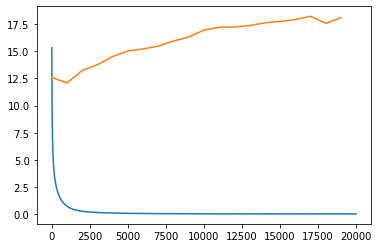

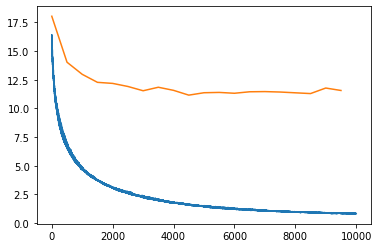

In [29]:
from tqdm import tqdm
import matplotlib.pyplot as plt

data_sched = [1, 3, 5, 10, 80, 80, 80, 80]
epoch_sched = [20000, 10000, 5000, 2000, 200, 200, 200, 200]
lr_sched = [5e-4, 2e-4, 1e-4, 5e-5, 2e-5, 1e-5, 5e-6, 2e-6]

for datasize, n_epochs, lr in zip(data_sched, epoch_sched, lr_sched):
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    train_use, discard_data = torch.utils.data.random_split(train_data, [datasize, 80 - datasize])
    del discard_data
    train_dataloader = DataLoader(train_use, batch_size=datasize, shuffle=True)

    train_losses = []
    val_losses = []
    for epoch in tqdm(range(n_epochs)):
        l_tot = 0
        num_batch = 0
        for X, y, _ in train_dataloader:
            preds = model(X.double())
            l = delay_loss(preds, y, loss, video_shft)
            #print('training loss:', l)
            l_tot += l.item()
            l.backward()
            optim.step()
            optim.zero_grad()
            num_batch += 1
    
        train_losses.append(l_tot/num_batch)   
        
        if epoch % (n_epochs//20) == 0:            
            l_val_tot = 0
            for X_val, y_val, _ in test_dataloader:
                preds_val = model(X_val.double())
                l_val = delay_loss(preds_val, y_val, loss, video_shft)
                l_val_tot += l_val.item()
            val_losses.append(l_val_tot)
            print('epoch: ', epoch)
            print('training loss:', l_tot/num_batch)   
            print('validation loss:', l_val_tot)

    fig, ax = plt.subplots()
    ax.plot(train_losses)
    ax.plot(list(range(0, n_epochs, n_epochs // 20)), val_losses)
    plt.savefig(f'losses_{datasize}_{n_epochs}_{lr}.png')
    del train_use, train_dataloader
            

In [ ]:
X_val, y_val, val_starts = test_dataloader.__iter__().next()
preds_val = model(X_val.double())
sample_pred = preds_val[0].detach().numpy()[video_shft:]
sample_lips = pca.inverse_transform(sample_pred)
true_lips = pca.inverse_transform(y_val[0])
print((val_starts[0])*30/100 + 12)

In [ ]:
#downsample predictions to 30 fps
preds_times = np.arange(video_start + val_starts[0], video_start + val_starts[0] + data.crop_len) / 100
downsample_times = np.arange(int(min(preds_times) * 30) + 1, int(max(preds_times) * 30)) / 30

preds_interpolate = interp1d(preds_times, sample_lips, axis = 0)
downsample_preds = preds_interpolate(downsample_times)

true_interpolate = interp1d(preds_times, true_lips, axis = 0)
downsample_true = true_interpolate(downsample_times)

print(min(downsample_times)*30, max(downsample_times)*30)
print(downsample_preds.shape)

In [ ]:
np.save('/content/drive/MyDrive/6869/sample_lips', sample_lips)
np.save('/content/drive/MyDrive/6869/downsample_preds', downsample_preds)
np.save('/content/drive/MyDrive/6869/downsample_true', downsample_true)

import pandas as pd
pd.DataFrame(sample_lips).to_csv('/content/drive/MyDrive/6869/sample_lips.csv', sep=' ', index=False, header=False)
pd.DataFrame(downsample_preds).to_csv('/content/drive/MyDrive/6869/downsample_preds.csv', sep=' ', index=False, header=False)

In [ ]:
25104*30/100 + 12